In [ ]:
from google.colab import files

uploaded_model1 = files.upload()





Saving model3a.csv to model3a.csv


In [5]:
#Part 1: Topic Modeling with NMF and Coherence Score Calculation


                                                text  111  112  113  114  115  \
0  I helped my friend with a difficult situation&...    1    0    0    0    0   
1  I went to the Durango state championships to s...    1    1    0    0    0   
2  I helped Eric with watering the plants and cle...    1    0    0    0    0   
3  I talked to my mom about my mental health and ...    1    0    0    0    1   
4  this experience I organized some wires for the...    1    0    0    0    0   

   116  121  122  123  ...  731  732  733  734  735  811  821  831  841  851  
0    0    0    0    0  ...    0    0    0    0    0    0    0    0    0    1  
1    0    0    0    0  ...    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0  ...    0    0    0    0    0    0    0    0    0    0  
3    0    1    0    0  ...    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0  ...    0    0    0    0    0    0    0    0    1    0  

[5 rows x 151 columns]
[0.609935131791

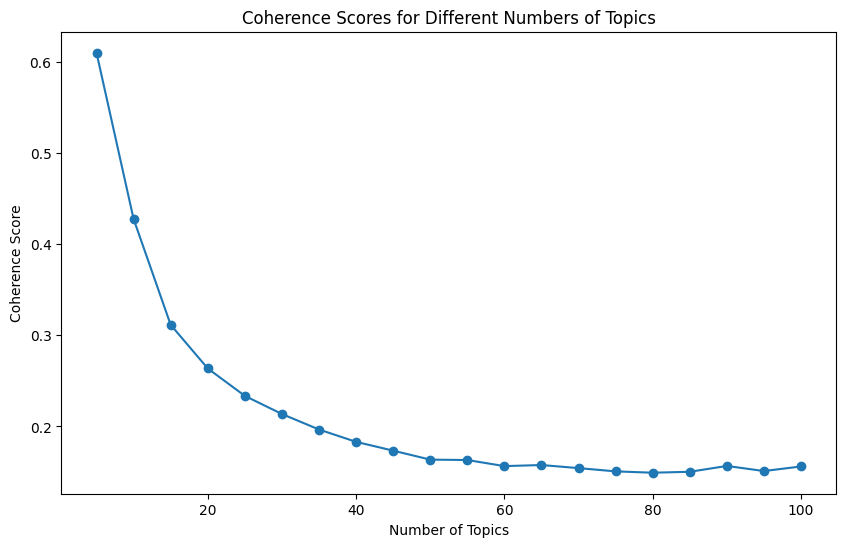

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings

# Load the dataset
data = pd.read_csv('model3a.csv', sep=',')

# Display the first few rows of the dataset
print(data.head())

# Basic EDA - Word Frequency Distribution
text_corpus = data['text'].values
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_corpus)
feature_names = vectorizer.get_feature_names_out()

# Calculate coherence scores for different numbers of topics
def calculate_coherence_score(num_topics):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=1000)  # Increase max_iter to 1000 or higher
            nmf_representation = nmf_model.fit_transform(tfidf_matrix)

            # Calculate pairwise cosine similarity between documents
            similarity_matrix = cosine_similarity(nmf_representation)

            # Calculate the mean similarity score as coherence score
            coherence_score = np.mean(similarity_matrix)

            return coherence_score
    except Exception as e:
        print(f"Error calculating coherence for {num_topics} topics: {e}")
        return np.nan




# Calculate coherence scores for different numbers of topics
num_topics_range = range(5, 101, 5)  # Adjust the range as needed
coherence_scores = [calculate_coherence_score(num_topics) for num_topics in num_topics_range]
print(coherence_scores)
# Find the optimal number of topics
optimal_num_topics = num_topics_range[np.argmax(coherence_scores)]
print(f"Optimal Number of Topics: {optimal_num_topics}")


# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Numbers of Topics')
plt.show()


In [ ]:
#Part 2: Matrix Factorization (NMF) and Neural Collaborative Filtering (NCF) Model

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

# Load the dataset
data = pd.read_csv('model3a.csv')

# Preprocess the data
# Convert labels to one-hot encoding
labels = data.iloc[:, 1:]
text_data = data['text']

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Matrix Factorization (NMF)
optimal_num_topics = 5
nmf = NMF(n_components=optimal_num_topics)
W = nmf.fit_transform(labels)
H = nmf.components_

# Neural Collaborative Filtering (NCF)
num_users = labels.shape[0]
num_items = labels.shape[1]
embedding_dim = 64

# Define NCF model
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

user_embedding = Embedding(num_users, embedding_dim)(user_input)
item_embedding = Embedding(num_items, embedding_dim)(item_input)

user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

concat = Concatenate()([user_flat, item_flat])

dense_1 = Dense(64, activation='relu')(concat)
dense_2 = Dense(32, activation='relu')(dense_1)

output = Dense(1, activation='sigmoid')(dense_2)

ncf_model = Model(inputs=[user_input, item_input], outputs=output)
ncf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train NCF model
user_indices = train_data.index
item_indices = range(num_items)
labels_train = labels.values

# Define positive and negative samples for training
def generate_samples():
    for user in user_indices:
        for item in item_indices:
            yield user, item, labels_train[user, item]

samples = np.array(list(generate_samples())).T
users_train = samples[0]
items_train = samples[1]
labels_train = samples[2]

ncf_model.fit([users_train, items_train], labels_train, epochs=20, batch_size=16)

# Save the model in the native Keras format
ncf_model.save('ncf_model.h5')

# Download the saved model file
from google.colab import files
files.download('ncf_model.h5')

# Recommendation for a given text
def recommend_labels(text, threshold=0.5):
    # Predict labels using NCF model
    user_idx = np.array([0] * num_items)  # Assuming user index 0 for recommendation
    item_idx = np.array(range(num_items))
    scores = ncf_model.predict([user_idx, item_idx])

    # Apply thresholding to get binary predictions
    binary_predictions = (scores > threshold).astype(int)

    # Get the indices of recommended labels based on thresholding
    recommended_labels = np.where(binary_predictions == 1)[0]

    return recommended_labels

# Example: Recommend labels for a given text
text_user_input = "I made a goal to make come up with an official project in Crafts for Service.&#10;I felt inspired&#10;I talked to peers about possible ideas&#10;That doing these projects can be fairly easy&#10;I wouldn&apos;t do anything differently except plan things sooner"
recommended_labels = recommend_labels(text_user_input)

# Print recommended labels
print("Recommended Microcredentials for the input text:")
for label in recommended_labels:
    print(f"Label {label}: {labels.columns[label]}")


Epoch 1/20
26372/26372 [==============================] - 181s 7ms/step - loss: 0.1160 - accuracy: 0.9655
Epoch 2/20
26372/26372 [==============================] - 168s 6ms/step - loss: 0.1015 - accuracy: 0.9686
Epoch 3/20
26372/26372 [==============================] - 175s 7ms/step - loss: 0.0934 - accuracy: 0.9707
Epoch 4/20
26372/26372 [==============================] - 175s 7ms/step - loss: 0.0882 - accuracy: 0.9723
Epoch 5/20
26372/26372 [==============================] - 167s 6ms/step - loss: 0.0841 - accuracy: 0.9736
Epoch 6/20
26372/26372 [==============================] - 167s 6ms/step - loss: 0.0803 - accuracy: 0.9748
Epoch 7/20
26372/26372 [==============================] - 163s 6ms/step - loss: 0.0767 - accuracy: 0.9762
Epoch 8/20
26372/26372 [==============================] - 165s 6ms/step - loss: 0.0728 - accuracy: 0.9773
Epoch 9/20
26372/26372 [==============================] - 190s 7ms/step - loss: 0.0692 - accuracy: 0.9785
Epoch 10/20
26372/26372 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5/5 [==============================] - 0s 3ms/step
Recommended Microcredentials for the input text:
Label 0: 111
Label 6: 121
Label 13: 132
Label 22: 146
Label 30: 218
Label 31: 219
Label 44: 246
Label 90: 544
Label 92: 546
Label 94: 548
Label 130: 651
Label 131: 652
